In [14]:
import pandas as pd
import numpy as np
import random
import os
np.random.seed(1)
random.seed(1)
TRAININFO = "/data/HitSongPrediction/train_info.tsv"
TRAINRANK =  "/data/HitSongPrediction/train_rank.csv"
TESTINFO = "/data/HitSongPrediction/test_info.tsv"
SUBMISSION = "/data/HitSongPrediction/submission.csv"

# Prepare data
df_i = pd.read_csv(TRAININFO, delimiter='\t',encoding='utf-8')
df_r = pd.read_csv(TRAINRANK)
df_i_train = df_i.merge(df_r, left_on='ID', right_on='ID')
df_i_train["dataset"] = "train"

df_i_test = pd.read_csv(TESTINFO, delimiter='\t',encoding='utf-8')
df_i_test["label"] = np.nan
df_i_test["dataset"] = "test"

df = pd.concat([df_i_train, df_i_test])
df_track_info = pd.read_csv("../../csv/all_track_info.csv")
df = df.merge(df_track_info, left_on='ID', right_on='ID')
df_audio_features = pd.read_csv("../../csv/all_track_audio_features.csv")
df =df.merge(df_audio_features,left_on="ID",right_on="ID", how="left")

df_album_hash = pd.read_csv("../../csv/album_hash.csv") 
df =df.merge(df_album_hash,left_on="ID",right_on="ID", how="left")

#Drop duplicate song
def remove_duplicate_songs_with_low_ranks(df):
    duplicateRowsDF = df[df.duplicated(["title", "album", "artist_name"], False)]
    duplicateRowsDF = duplicateRowsDF[~duplicateRowsDF.label.isnull()]
    all_index = duplicateRowsDF.index

    duplicateRowsDF= duplicateRowsDF.sort_values(by=['label'])
    duplicateRowsDF = duplicateRowsDF.drop_duplicates(["title", "album", "artist_name"],keep="first")
    keep_index = duplicateRowsDF.index

    remove_index = list(set(all_index) - set(keep_index))
    df = df.drop(remove_index)
    return df
# df = remove_duplicate_songs_with_low_ranks(df)

# Sort by ID
df = df.sort_values(by=['ID'])
df= df.reset_index()

print(len(df))
# df.head(5683)

10196


In [ ]:
pd.set_option('display.max_rows', 10000)
df["num_len_same"] = df.groupby(["length","artist_id"])["ID"].transform("count")
df1 = df[df.num_len_same > 1]

df1 = df1.sort_index(by="length")
df1[["ID","title", "album", "album_artist", "artist_name","genre", "composers_name", "track","release_time","length","label"]]

In [ ]:
df['title_truncated'] = df['title'].str.split('(', expand=True).loc[:, 0].str.rstrip().str.rstrip('!').str.rstrip(
        '?')

len(df.title_truncated.unique())

In [ ]:
def no_bracket(tit):
    return tit.split('(')[0]

df['no_bracket_title'] = df.title.apply(lambda x: no_bracket(x))
len(df.no_bracket_title.unique())

In [ ]:
duplicateRowsDF = df[df.duplicated(["title", "album", "artist_name"], False)]
duplicateRowsDF

In [ ]:
df[df.length==0][["title", "album", "album_artist", "artist_name","genre", "composers_name", "track","release_time","length","label"]]

In [15]:
import seaborn as sns
# Fill nan album
print("There is {} ratio is nan album".format(len(df[df["album"].isnull()])/len(df)))
print("There is {} ratio is nan album".format(len(df[df["album"].isnull()])/len(df)))

df["album_right"] = df.release_time.astype("category").cat.codes
df["albumHashAndName"] = df["album_hash"].fillna(df['album'])
df["albumHashAndNameAndReleaseday"] = df["albumHashAndName"].fillna(df['album_right']).astype("category").cat.codes
assert df['albumHashAndNameAndReleaseday'].isnull().sum() == 0

df["album_tmp"]  = df["album"].copy()

df["album"]  = df["album"].fillna("")
df["len_album_name"] = df["album"].apply(lambda x: len(x.split(" ")))
df["isRemixAlbum"] = [ 1 if "Remix" in t else 0 for t in df["album"]]
# df["isRemixAlbum"] = df["isRemixAlbum"].astype(bool)

df["isOSTAlbum"] = [ 1 if "OST" in t else 0 for t in df["album"]]
# df["isOSTAlbum"] = df["isOSTAlbum"].astype(bool)


df["isSingleAlbum"] = [ 1 if "Single" in t else 0 for t in df["album"]]
df["isSingleAlbum"] = df["isSingleAlbum"].astype(bool)

df["isBeatAlbum"] = [ 1 if "Beat" in t else 0 for t in df["album"]]
# df["isBeatAlbum"] = df["isBeatAlbum"].astype(bool)

df["isTopHitAlbum"] = [ 1 if "Top Hits" in t else 0 for t in df["album"]]
# df["isTopHitAlbum"] = df["isTopHitAlbum"].astype(bool)


df["isCoverAlbum"] = [ 1 if "Cover" in t else 0 for t in df["album"]]
# df["isCoverAlbum"] = df["isCoverAlbum"].astype(bool)


df["isEPAlbum"] = [ 1 if "EP" in t else 0 for t in df["album"]]
# df["isEPAlbum"] = df["isEPAlbum"].astype(bool)


df["isLienKhucAlbum"] = [ 1 if "Liên Khúc" in t else 0 for t in df["album"]]
# df["isLienKhucAlbum"] = df["isLienKhucAlbum"].astype(bool)


def no_bracket(tit):
    return tit.split('(')[0]

df['no_bracket_title'] = df.title.apply(lambda x: no_bracket(x))
df["num_same_title_no_bracket"] = df.groupby("no_bracket_title")["no_bracket_title"].transform("count")
df['no_bracket_title_cat'] = df['no_bracket_title'].astype('category').cat.codes


df['title_truncated'] = df['title'].str.split('(', expand=True).loc[:, 0].str.rstrip().str.rstrip('!').str.rstrip(
        '?').astype('category').cat.codes
df["isEDM"] = [ 1 if "EDM" in t else 0 for t in df["title"]]
# df["isEDM"] = df["isEDM"].astype(bool)

df["isDJ"] = [ 1 if "DJ" in t else 0 for t in df["title"]]
# df["isDJ"] = df["isDJ"].astype(bool)

df["isMix"] = [ 1 if "Mix" in t else 0 for t in df["title"]]
# df["isMix"] = df["isMix"].astype(bool)

df["isLive"] = [ 1 if "Live" in t else 0 for t in df["title"]]
# df["isLive"] = df["isLive"].astype(bool)



df["num_same_title"] = df.groupby("title")["title"].transform("count")
df["title_cat"] = df["title"].astype('category').cat.codes
df["album_name_is_title_name"]= [1 if r.title in r.album  else 0 for i,r in df.iterrows() ]
df["album"] = df["album"].astype('category')
df["album"] =  df["album"].cat.codes

df["artist_name_cat"] = df["artist_name"].astype('category')
df["artist_name_cat"] =  df["artist_name_cat"].cat.codes
df["composers_name_cat"] = df["composers_name"].astype('category')
df["composers_name_cat"] =  df["composers_name_cat"].cat.codes
df["copyright_cat"] = df["copyright"].astype('category')
df["copyright_cat"] =  df["copyright_cat"].cat.codes

import re
def get_min_artist_id(s):
    ps = re.split(',|\.',s)
    ps = [int(p) for p in ps]
    return np.min(ps)

def get_max_artist_id(s):
    ps = re.split(',|\.',s)
    ps = [int(p) for p in ps]
    return np.max(ps)

df["artist_id_min"]=  df["artist_id"].apply(lambda x: get_min_artist_id(x))
df["artist_id_min_cat"] = df["artist_id_min"].astype('category')
df["artist_id_min_cat"] =  df["artist_id_min_cat"].cat.codes

df["composers_id_min"]=  df["composers_id"].apply(lambda x: get_min_artist_id(x))
df["composers_id_min_cat"] = df["composers_id_min"].astype('category')
df["composers_id_min_cat"] =  df["composers_id_min_cat"].cat.codes

df["artist_id_max"]=  df["artist_id"].apply(lambda x: get_max_artist_id(x))
df["artist_id_max_cat"] = df["artist_id_max"].astype('category')
df["artist_id_max_cat"] =  df["artist_id_max_cat"].cat.codes

df["composers_id_max"]=  df["composers_id"].apply(lambda x: get_max_artist_id(x))
df["composers_id_max_cat"] = df["composers_id_max"].astype('category')
df["composers_id_max_cat"] =  df["composers_id_max_cat"].cat.codes

#New feature
# df["group_album_artist_id_min_cat"] = df.groupby(["album","artist_id_min_cat"]).ngroup()
# df["group_album_artist_id_min_cat"] = df["group_album_artist_id_min_cat"].astype("category").cat.codes
# df["group_album_artist_id_max_cat"] = df.groupby(["album","artist_id_max_cat"]).ngroup()
# df["group_album_artist_id_max_cat"] = df["group_album_artist_id_max_cat"].astype("category").cat.codes


# Fill genre
print("There is {} ratio is nan genre".format(len(df[df["genre"].isnull()])/len(df)))
df["genre"]  = df["genre"].fillna("No genre")
df["genre"] = df["genre"].astype('category')
df["genre"] =  df["genre"].cat.codes

# Fill album_artist
print("There is {} ratio is nan album_artist".format(len(df[df["album_artist"].isnull()])/len(df)))
df["album_artist"]  = df["album_artist"].fillna("No album_artist")
df["album_artist_contain_artistname"]= [1 if r.album_artist in r.artist_name  else 0 for i,r in df.iterrows() ]
df["album_artist"] = df["album_artist"].astype('category')
df["album_artist"] =  df["album_artist"].cat.codes

# Fill track
print("There is {} ratio is nan track".format(len(df[df["track"].isnull()])/len(df)))
df["track_tmp"]  = df["track"].copy()
df["track"]  = df["track"].fillna("(1, 1)")
df["istrack11"] = df["track"] == "(1, 1)"
def tracknum_to_value(track_num):
    try:
        
        track_num = make_tuple(track_num)
        if track_num[0] is not None:
            return float(track_num[0]) / float(track_num[1])
        else:
            return 1.0
    except:
        return 1.0

df["track"] = df["track"].apply(lambda t: tracknum_to_value(t))


# Fill lyric
print("There is {} ratio is nan lyric".format(len(df[df["lyric"].isnull()])/len(df)))
df["lyric"]  = df["lyric"].fillna("")
df["islyric"] = df["lyric"].apply(lambda x:  True if len(x)  else False)
df["num_line_lyric"] = df["lyric"].apply(lambda x : len(x.split("\r")))


#--------------------------------------------------------
from dateutil import relativedelta
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval as make_tuple
df['no_artist'] = df.artist_name.apply(lambda x: len(x.split(",")))
df['no_composer'] = df.composers_name.apply(lambda x: len(x.split(",")))
df["freq_artist"] = df.groupby('artist_id')['artist_id'].transform('count').astype('float')
df["freq_composer"] = df.groupby('composers_id')['composers_id'].transform('count').astype('float')
df["freq_artist_min"] = df.groupby('artist_id_min_cat')['artist_id_min_cat'].transform('count').astype('float')
df["freq_composer_min"] = df.groupby('composers_id_min_cat')['composers_id_min_cat'].transform('count').astype('float')

df["num_album_per_min_artist"] = df.groupby(['artist_id_min_cat','album_right'])['album_right'].transform('count').astype('float')
df["num_album_per_min_composer"] = df.groupby(['composers_id_min','album_right'])['album_right'].transform('count').astype('float')


df["datetime"] = pd.to_datetime(df.release_time)
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["dayofyear"] = df["datetime"].dt.dayofyear
df["weekday"] = df["datetime"].dt.weekday
from datetime import date 
import holidays 

in_holidays = holidays.HolidayBase() 
for i in range(26,32):
    in_holidays.append(str(i)+'-01-2017')
in_holidays.append('01-02-2017')
for i in range(14,21):
    in_holidays.append(str(i)+'-02-2018')
in_holidays.append('30-04-2017')
in_holidays.append('30-04-2018')
in_holidays.append('01-01-2017')
in_holidays.append('01-01-2018')
in_holidays.append('14-02-2017')
in_holidays.append('14-02-2018')
in_holidays.append('08-03-2017')
in_holidays.append('08-03-2018')
in_holidays.append('01-05-2017')
in_holidays.append('01-05-2018')
in_holidays.append('06-04-2017')
in_holidays.append('25-04-2018')
in_holidays.append('01-06-2017')
in_holidays.append('01-06-2018')
in_holidays.append('04-10-2017')
in_holidays.append('24-09-2018')
in_holidays.append('20-10-2017')
in_holidays.append('20-10-2018')
in_holidays.append('20-11-2017')
in_holidays.append('20-11-2018')
in_holidays.append('24-12-2017')
in_holidays.append('24-12-2018')
df['isHoliday'] = df.release_time.apply(lambda x: x in in_holidays)



df["len_of_songname"] = df["title"].apply(lambda x: len(x.split(" ")))
df["isRemix"] = [ 1 if "Remix" in t else 0 for t in df["title"]]
df["isRemix"] = df["isRemix"].astype(bool)

df["isOST"] = [ 1 if "OST" in t else 0 for t in df["title"]]
df["isOST"] = df["isOST"].astype(bool)

df["isBeat"] = [ 1 if "Beat" in t else 0 for t in df["title"]]
df["isBeat"] = df["isBeat"].astype(bool)

df["isVersion"] = [ 1 if "Version" in t else 0 for t in df["title"]]
df["isVersion"] = df["isVersion"].astype(bool)

df["isCover"] = [ 1 if "Cover" in t else 0 for t in df["title"]]
df["isCover"] = df["isCover"].astype(bool)


df["isLienKhuc"] = [ 1 if "Liên Khúc" in t else 0 for t in df["title"]]
df["isLienKhuc"] = df["isLienKhuc"].astype(bool)



def find_num_song_release_in_final_month(df, day):
    month5th = day + relativedelta.relativedelta(months=5)
    month6th = day + relativedelta.relativedelta(months=6)  
    return len(df.datetime[(df.datetime >= month5th)&(df.datetime<=month6th)])



df["num_song_release_in_final_month"] = df.datetime.apply(lambda d:find_num_song_release_in_final_month(df ,d))

#It seems like all songs on albums release at the same time, so groupby by release_time will create album 

df["day_release"] = df.groupby(["year","dayofyear"]).ngroup().astype("category").cat.codes
df["numsongInAlbum"] = df.groupby("album_right")["album_right"].transform("count")
df["isSingleAlbum_onesong"]= df["isSingleAlbum"] & (df["numsongInAlbum"]==1)

# Remove len =0
df = df[(df.length>0) | (df.num_same_title==1)]

There is 0.24038838760298156 ratio is nan album
There is 0.24038838760298156 ratio is nan album
There is 0.0017653981953707335 ratio is nan genre
There is 0.24038838760298156 ratio is nan album_artist
There is 0.0007846214201647705 ratio is nan track
There is 0.6722244017261672 ratio is nan lyric


In [ ]:
def remove_song_that_have_abnormal_rank_in_album(df):
    df["m"] = df.groupby("albumHashAndNameAndReleaseday")["label"].transform("mean")
    df["std"] = df.groupby("albumHashAndNameAndReleaseday")["label"].transform("std")
    df["count"] = df.groupby("albumHashAndNameAndReleaseday")["label"].transform("count")

#     pd.set_option('display.max_rows', 100957)

    df = df.sort_index(by="albumHashAndNameAndReleaseday")
    df[df.dataset=="train"][["albumHashAndNameAndReleaseday","label","m","std", "count"]]

    condition = (df["count"] >=10) & (np.abs(df.label - df.m) > 1.5*df["std"])
    print("len df:", len(df))
    df1 = df[~condition]
    print("len df:", len(df1))
    df = df1.copy()
    df = df.sort_values(by=['ID'])
    df= df.reset_index()
    return df
df= remove_song_that_have_abnormal_rank_in_album(df)

In [ ]:
pd.set_option('display.max_rows', 100957)
df = df.sort_values(by=['albumHashAndNameAndReleaseday'])
print(len(df))
df[["ID","title", "album_tmp", "album_hash", "albumHashAndNameAndReleaseday","artist_name", "track_tmp","release_time","length","label"]].head(1000)

In [24]:
from datetime import datetime
import re

def split_id(s):
    return re.split(',|\.',s)

m = df.artist_id.unique()
idx_lst = []
for idx in m:
    ps = split_id(idx)
    for i in ps:
        idx_lst.append(i)
        
id_lst = list(set(idx_lst))

def condition(df, artist_id):
    r = df.artist_id.apply(lambda x: artist_id in split_id(x))
    return r

df_train = df[df.dataset=="train"]
data= [df_train[condition(df_train, artist_id)].label.agg(["mean","std","count","median","min","max"]) for artist_id in id_lst]
new_df = pd.DataFrame(data=data)
new_df["artist_id"] =  id_lst

new_df.dropna(inplace=True)
new_df.set_index('artist_id', inplace=True)
art_dict = new_df.to_dict()

def best_count_id(values):
    ids = split_id(values)
    temp_mean = 0
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['count'][id] > temp_mean:
                temp_mean = art_dict['count'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id

def worst_count_id(values):
    ids = split_id(values)
    temp_mean = 0
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['count'][id] < temp_mean:
                temp_mean = art_dict['count'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id
    
df['artist_count_id'] = df['artist_id'].apply(best_count_id)
df['artist_worstcount_id'] = df['artist_id'].apply(worst_count_id)


def best_mean_id(values):
    ids = split_id(values)
    temp_mean = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['mean'][id] < temp_mean:
                temp_mean = art_dict['mean'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id

def best_min_id(values):
    ids = split_id(values)
    temp_mean = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['min'][id] < temp_mean:
                temp_mean = art_dict['min'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id

df['artist_bestmin_id'] = df['artist_id'].apply(best_min_id)

def best_max_id(values):
    ids = split_id(values)
    temp_mean = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['max'][id] < temp_mean:
                temp_mean = art_dict['max'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id

df['artist_bestmax_id'] = df['artist_id'].apply(best_max_id)

def worst_mean_id(values):
    ids = split_id(values)
    temp_mean = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['mean'][id] > temp_mean:
                temp_mean = art_dict['mean'][id]
                temp_id = id
        except:
            temp_mean = temp_mean
            temp_id = temp_id
    return temp_id

df['artist_mean_id'] = df['artist_id'].apply(best_mean_id)
df['artist_worstmean_id'] = df['artist_id'].apply(worst_mean_id)


def best_std_id(values):
    ids = split_id(values)
    temp_std = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['std'][id] < temp_std:
                temp_std = art_dict['std'][id]
                temp_id = id
        except:
            temp_std = temp_std
            temp_id = temp_id
    return temp_id

def worst_std_id(values):
    ids = split_id(values)
    temp_std = 10
    temp_id = str(min([int(a) for a in ids]))
    for id in ids:
        try:
            if art_dict['std'][id] > temp_std:
                temp_std = art_dict['std'][id]
                temp_id = id
        except:
            temp_std = temp_std
            temp_id = temp_id
    return temp_id

df['artist_std_id'] = df['artist_id'].apply(best_std_id)
df['artist_worststd_id'] = df['artist_id'].apply(worst_std_id)


df['artist_mean_id'] = df['artist_mean_id'].astype("category")
df['artist_std_id'] = df['artist_std_id'].astype("category")
df['artist_count_id'] = df['artist_count_id'].astype("category")

df['artist_worstcount_id'] = df['artist_worstcount_id'].astype("category")
df['artist_worstmean_id'] = df['artist_worstmean_id'].astype("category")
df['artist_worststd_id'] = df['artist_worststd_id'].astype("category")

df['artist_bestmin_id']=df['artist_bestmin_id'].astype("category")
df['artist_bestmax_id']=df['artist_bestmax_id'].astype("category")



In [38]:
from functools import reduce

def create_album_score_lookup_table(df):
    data = df.groupby('album_right').label.agg(["mean","std","count", "min","max"])
    return data

def create_artist_score_lookup_table(df):
    def split_id(s):
        return re.split(',|\.',s)
    
    def mask_row_contain_artist_id(df, artist_id):
        r = df.artist_mean_id.apply(lambda x: artist_id in split_id(x))
        return r
    
    # Get all artist ids
    artist_group = df.artist_mean_id.unique()
    artist_ids = reduce(lambda l,e: l+split_id(e), artist_group, [])
    artist_ids = list(set(artist_ids))
    # Get data
    data= [df[mask_row_contain_artist_id(df, artist_id)].label.agg(["mean","std","count", "median","min","max"]) 
                                                        for artist_id in artist_ids]
    new_df = pd.DataFrame(data=data)
    new_df["artist_mean_id"] =  artist_ids
    return new_df.set_index("artist_mean_id")
    




In [27]:
def get_field_by_key(table, k, field="mean"):
    if k in table.index:
        return table.loc[k][field]
    return np.nan

def get_value_by_key(table, k):
    if k in table.index:
        return table.loc[k], False
    return np.nan, True

def assign_value(album_table, artist_table, r):
    d1,isnul1 = get_value_by_key(album_table, r.album_right)
    d2,isnul2 = get_value_by_key(artist_table, r.artist_mean_id)
#     print(type(d2),isnul2)
    if isnul1 and isnul2:
        return np.nan
    elif isnul1 and d2["std"] <2:
        return d2["mean"]
    elif isnul2 and d1["std"] <2:
        return d1["mean"]
    
    elif not isnul1 and d1["std"] <2 and not isnul2 and d2["std"] < 2:
        return d1["mean"] 
    
    
    return np.nan

def assign_value_album(album_table, r):
    d1,isnul1 = get_value_by_key(album_table, r.album_right)
    
    if not isnul1 and d1["std"] <2:
        return d1["mean"]
    
    return np.nan
    
def assign_value_artist(artist_table, r):
    d1,isnul1 = get_value_by_key(artist_table, r.artist_mean_id)
    
    if not isnul1 and d1["std"] <2:
        return d1["mean"]
    
    return np.nan

def assign_value_album_min(album_table, r):
    d1,isnul1 = get_value_by_key(album_table, r.album_right)
    
    if not isnul1 and d1["std"] <2:
        return d1["min"]
    
    return np.nan
    
def assign_value_artist_min(artist_table, r):
    d1,isnul1 = get_value_by_key(artist_table, r.artist_mean_id)
    
    if not isnul1 and d1["std"] <2:
        return d1["min"]
    
    return np.nan
    
def assign_value_album_max(album_table, r):
    d1,isnul1 = get_value_by_key(album_table, r.album_right)
    
    if not isnul1 and d1["std"] <2:
        return d1["max"]
    
    return np.nan
    
def assign_value_artist_max(artist_table, r):
    d1,isnul1 = get_value_by_key(artist_table, r.artist_mean_id)
    
    if not isnul1 and d1["std"] <2:
        return d1["max"]
    
    return np.nan

In [ ]:
df.artist_mean_id

In [ ]:
import xam

encoder = xam.feature_extraction.BayesianTargetEncoder(
    columns=['album_right', 'artist_mean_id',"artist_id_min_cat",
             "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat"],
    prior_weight=10000,
    suffix='_encode')

# df_train = df[df.dataset=="train"]

target_encode = encoder.fit_transform(df[['album_right', 'artist_mean_id',"artist_id_min_cat",
             "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat"]], df.label )



In [ ]:
target_encode

In [ ]:
def baysianEncodeFeature(df_train, trn_idx, featurename, prior_weight, fillmissing, suffix='_baysencoded'):
    '''Returns new df '''
    import xam

    encoder = xam.feature_extraction.BayesianTargetEncoder(
        columns=[featurename, ],
        prior_weight=prior_weight,
        suffix=suffix)

    train_df_fold = df_train.iloc[trn_idx]

    encoder.fit(train_df_fold[[featurename]], train_df_fold.label)

    _resulting_df = encoder.transform(df_train[[featurename]], df_train.label)
    _resulting_df[featurename + suffix] = _resulting_df[featurename + suffix].astype('float64')
    _resulting_df[featurename + suffix].fillna(fillmissing, inplace=True)

    # Add the column to original df_train
    df_train[featurename + suffix] = _resulting_df[featurename + suffix].round(0).astype('int64')
    return df_train

In [47]:
### 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split

# chosen_features = [ "albumHashAndNameAndReleaseday","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
#                    "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
#                   "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
#                   "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
#                   "isBeatAlbum", "isCoverAlbum", "artist_name_cat","composers_name_cat","copyright_cat" ,
#                   "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
#                    "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
#                   "num_album_per_min_artist", "num_album_per_min_composer", 
#                    "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
#                    "artist_std_id" ,"artist_count_id","title_cat","num_same_title"]

chosen_features = [ "album_right","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name_cat","composers_name_cat","copyright_cat" ,
                  "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
                   "artist_std_id" ,"artist_count_id","title_cat","num_same_title"]
#                      'artist_worstcount_id', 'artist_worstmean_id',  'artist_worststd_id']
# df['artist_worstcount_id'] = df['artist_worstcount_id'].astype("category")
# df['artist_worstmean_id'] = df['artist_worstmean_id'].astype("category")
# df['artist_worststd_id'] = df['artist_worststd_id'].astype("category")


# chosen_features += ["mean1"]
#                     , "mean2"]
#                     "std1","std2", "min1", "min2", "max1", "max2"]
# encode_features = ['album_right', 'artist_mean_id',"artist_id_min_cat",
#                      "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat"]

# encode_features=[ 'artist_mean_id',"artist_id_min_cat",
#                      "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat"]
# encode_features = [f+"_encode" for f in encode_features]

# df[encode_features] = target_encode[encode_features]

# chosen_features = [ "istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
#                    "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
#                   "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
#                   "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
#                   "isBeatAlbum", "isCoverAlbum", "artist_name_cat","composers_name_cat","copyright_cat" ,
#                    "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
#                   "num_album_per_min_artist", "num_album_per_min_composer", 
#                    "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
#                    "artist_std_id" ,"artist_count_id","title_cat","num_same_title"]

# chosen_features =[]
# chosen_features += encode_features
# chosen_features = ["album_right","freq_artist",  "day", 
#                      "isBeat",  "num_song_release_in_final_month",
#                   "length","album_artist",
#                   "artist_name_cat","composers_name_cat",
#                   "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
#                    "freq_artist_min","dayofyear", 
#                    "numsongInAlbum","artist_mean_id","artist_std_id" ,"artist_count_id" ]


# chosen_features = [  "istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
#                    "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
#                   "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
#                   "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
#                   "isBeatAlbum", "isCoverAlbum","copyright_cat" ,
#                   "composers_id_min_cat",
#                    "freq_artist_min", "freq_composer_min","dayofyear","weekday",
#                   "num_album_per_min_artist", "num_album_per_min_composer", 
#                    "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id", "artist_std_id" ,"artist_count_id"]

chosen_features  += ["predicted_label"]
# chosen_features += ["mean_album_score", "mean_artist_min_score"]
df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]

param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
       'num_leaves': 50,            
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels= df_train.label
# fig, axes = plt.subplots(5, 1, figsize=(10, 10*5))
# axes = axes.flat
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.label.values)):
    print("Fold {}".format(fold_))
#     if fold_ in range(0,3):
#         continue
    # Create lookup table
    album_lookup_table = create_album_score_lookup_table(df_train.iloc[trn_idx])
    artist_lookup_table = create_artist_score_lookup_table(df_train.iloc[trn_idx])
    
#     df_train["mean_album_score"]= [assign_value_album(album_lookup_table, r) for i, r in df_train.iterrows()]
#     df_train["mean_artist_min_score"]= [assign_value_artist(artist_lookup_table, r) for i, r in df_train.iterrows()]
    #df_train = baysianEncodeFeature(df_train, trn_idx, 'albumHashAndNameAndReleaseday', prior_weight=4, fillmissing=-1, suffix='_enc')
    #df_train = baysianEncodeFeature(df_train, trn_idx, 'artist_id_min', prior_weight=4, fillmissing=-1, suffix='_enc')
#     df_train = baysianEncodeFeature(df_train, trn_idx, 'title_truncated', prior_weight=4, fillmissing=-1, suffix='_enc')
    
    df_train["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_train.iterrows()]
#     print("Percentage null in valid:", np.sum(df_train.iloc[val_idx]["predicted_label"].isnull()) / len(df_train.iloc[val_idx]))
    df_test["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_test.iterrows()]
#     print("Percentage null in test:", np.sum(df_test["predicted_label"].isnull()) / len(df_test))
#     "mean","std","count", "min","max"
    
#     df_train["mean1"] = [get_field_by_key(album_lookup_table, r.album_right, field="mean") for i, r in df_train.iterrows()]
#     df_test["mean1"] = [get_field_by_key(album_lookup_table, r.album_right, field="mean") for i, r in df_test.iterrows()]
    
#     df_train["mean2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="mean") for i, r in df_train.iterrows()]
#     df_test["mean2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="mean") for i, r in df_test.iterrows()]
    
    
#     df_train["std1"] = [get_field_by_key(album_lookup_table, r.album_right, field="std") for i, r in df_train.iterrows()]
#     df_test["std1"] = [get_field_by_key(album_lookup_table, r.album_right, field="std") for i, r in df_test.iterrows()]
    
#     df_train["std2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id ,field="std") for i, r in df_train.iterrows()]
#     df_test["std2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="std") for i, r in df_test.iterrows()]
    
#     df_train["min1"] = [get_field_by_key(album_lookup_table, r.album_right, field="min") for i, r in df_train.iterrows()]
#     df_test["min1"] = [get_field_by_key(album_lookup_table, r.album_right, field="min") for i, r in df_test.iterrows()]
    
#     df_train["min2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="min") for i, r in df_train.iterrows()]
#     df_test["min2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="min") for i, r in df_test.iterrows()]
    
#     df_train["max1"] = [get_field_by_key(album_lookup_table, r.album_right, field="max") for i, r in df_train.iterrows()]
#     df_test["max1"] = [get_field_by_key(album_lookup_table, r.album_right, field="max") for i, r in df_test.iterrows()]
    
#     df_train["max2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="max") for i, r in df_train.iterrows()]
#     df_test["max2"] = [get_field_by_key(artist_lookup_table, r.artist_mean_id, field="max") for i, r in df_test.iterrows()]
    
#     df_train["mean1"] = [get_field_by_key(album_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
#     df_train["mean2"] = [get_field_by_key(artist_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
    
#      df_train["mean1"] = [get_field_by_key(album_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
#     df_train["mean2"] = [get_field_by_key(artist_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
    
#      df_train["mean1"] = [get_field_by_key(album_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
#     df_train["mean2"] = [get_field_by_key(artist_lookup_table, r, field="mean") for i, r in df_train.iterrows()]
    
    
    
    
    
    
    
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][chosen_features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][chosen_features], label=labels.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds =20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits



Fold 0


/home/vuthede/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vuthede/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 20000 rounds
[5000]	training's rmse: 1.5814	valid_1's rmse: 1.79091
[10000]	training's rmse: 1.29081	valid_1's rmse: 1.66743
[15000]	training's rmse: 1.12789	valid_1's rmse: 1.62073
[20000]	training's rmse: 1.01066	valid_1's rmse: 1.59558
[25000]	training's rmse: 0.920075	valid_1's rmse: 1.57971
[30000]	training's rmse: 0.845951	valid_1's rmse: 1.56871
[35000]	training's rmse: 0.783362	valid_1's rmse: 1.56074
[40000]	training's rmse: 0.728227	valid_1's rmse: 1.55478
[45000]	training's rmse: 0.680482	valid_1's rmse: 1.55029
[50000]	training's rmse: 0.637535	valid_1's rmse: 1.54612
[55000]	training's rmse: 0.59904	valid_1's rmse: 1.54302
[60000]	training's rmse: 0.56392	valid_1's rmse: 1.54038
[65000]	training's rmse: 0.532389	valid_1's rmse: 1.5386
[70000]	training's rmse: 0.503323	valid_1's rmse: 1.53704
[75000]	training's rmse: 0.476972	valid_1's rmse: 1.53569
[80000]	training's rmse: 0.452371	valid_1's rmse: 1.5346
[85000]	training's

[90000]	training's rmse: 0.405394	valid_1's rmse: 1.58909
[95000]	training's rmse: 0.386125	valid_1's rmse: 1.5885
[100000]	training's rmse: 0.367685	valid_1's rmse: 1.588
[105000]	training's rmse: 0.351071	valid_1's rmse: 1.58745
[110000]	training's rmse: 0.335439	valid_1's rmse: 1.5871
[115000]	training's rmse: 0.320769	valid_1's rmse: 1.58687
[120000]	training's rmse: 0.306794	valid_1's rmse: 1.58665
[125000]	training's rmse: 0.294068	valid_1's rmse: 1.58662
[130000]	training's rmse: 0.281991	valid_1's rmse: 1.58661
[135000]	training's rmse: 0.270487	valid_1's rmse: 1.58653
[140000]	training's rmse: 0.25979	valid_1's rmse: 1.58639
[145000]	training's rmse: 0.249566	valid_1's rmse: 1.58625
[150000]	training's rmse: 0.240124	valid_1's rmse: 1.58615
[155000]	training's rmse: 0.231221	valid_1's rmse: 1.5863
[160000]	training's rmse: 0.222564	valid_1's rmse: 1.58631
[165000]	training's rmse: 0.214599	valid_1's rmse: 1.58622
[170000]	training's rmse: 0.20704	valid_1's rmse: 1.58632
Early 

[60000]	training's rmse: 0.557586	valid_1's rmse: 1.62656
[65000]	training's rmse: 0.526184	valid_1's rmse: 1.62377
[70000]	training's rmse: 0.49754	valid_1's rmse: 1.62155
[75000]	training's rmse: 0.471255	valid_1's rmse: 1.61947
[80000]	training's rmse: 0.447268	valid_1's rmse: 1.61797
[85000]	training's rmse: 0.425049	valid_1's rmse: 1.61662
[90000]	training's rmse: 0.404408	valid_1's rmse: 1.61559
[95000]	training's rmse: 0.385322	valid_1's rmse: 1.61462
[100000]	training's rmse: 0.367521	valid_1's rmse: 1.61393
[105000]	training's rmse: 0.351267	valid_1's rmse: 1.6133
[110000]	training's rmse: 0.336036	valid_1's rmse: 1.61292
[115000]	training's rmse: 0.321742	valid_1's rmse: 1.61257
[120000]	training's rmse: 0.308192	valid_1's rmse: 1.61232
[125000]	training's rmse: 0.29574	valid_1's rmse: 1.61206
[130000]	training's rmse: 0.283719	valid_1's rmse: 1.6119
[135000]	training's rmse: 0.272424	valid_1's rmse: 1.61165
[140000]	training's rmse: 0.261956	valid_1's rmse: 1.61153
[145000]	

In [ ]:
pd.set_option('display.max_rows', 2000)
df_train["mae"] = np.abs(df_train.label - oof)
df_train["prediction"] =  oof
df_train.to_csv("results.csv")
df_err = df_train.sort_values(by="mae", ascending=False)

df_err[["label", "prediction", "mae", "numsongInAlbum","album_tmp", "albumHashAndNameAndReleaseday"]].head(1000)

In [ ]:
df_train[df_train.albumHashAndNameAndReleaseday==2137][["ID","artist_name","m","std","title","label", "prediction", "mae","genre" ,"release_time", "composers_id","numsongInAlbum","album_tmp", "track_tmp","albumHashAndNameAndReleaseday"]]

In [ ]:
# Co chu bo
#

In [ ]:
df[df.title=="Người Thương Thành Người Dưng"]

In [48]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print("RMSE: {:<8.5f}".format(sqrt(mean_squared_error(df_train.label, oof))))
sub = pd.DataFrame({"ID": df_test.ID.values})
sub["label"] = predictions
sub.to_csv("submission_lightgbm.csv", index=False, header=False)

RMSE: 1.54750 


In [ ]:
plt.hist(sub.label)

<Figure size 2160x2160 with 0 Axes>

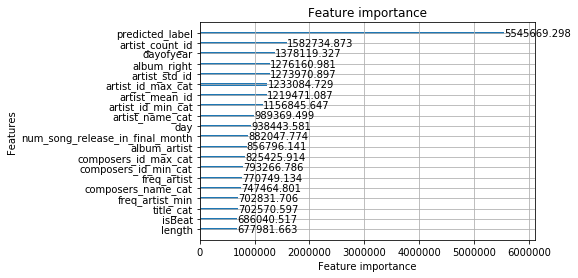

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,30))
lgb.plot_importance(clf, max_num_features=20,importance_type='gain')


In [23]:
#https://www.kaggle.com/slundberg/interpreting-a-lightgbm-model
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as pl
import gc
import shap
from sklearn.externals import joblib
explainer = shap.TreeExplainer(clf)
X_test= df_train.iloc[val_idx][chosen_features]
shap_values = explainer.shap_values(X_test.iloc[:10000,:])

# save model
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
# global_importances = np.abs(shap_values).mean(0)[:-1]

# # make a bar chart that shows the global importance of the top 20 features
# inds = np.argsort(-global_importances)
# f = pl.figure(figsize=(5,10))
# y_pos = np.arange(20)
# inds2 = np.flip(inds[:20], 0)
# pl.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
# pl.yticks(y_pos, fontsize=13)
# pl.gca().set_yticklabels(df_train[best_chosen_features].columns[inds2])
# pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
# pl.gca().xaxis.set_ticks_position('bottom')
# pl.gca().yaxis.set_ticks_position('none')
# pl.gca().spines['right'].set_visible(False)
# pl.gca().spines['top'].set_visible(False)

KeyboardInterrupt: 